## Main method with test over the tesla stock

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Load the dataset
file_path = 'tsla_data (1).csv'  # Replace with the correct file path
data = pd.read_csv(file_path, delimiter=';')

# Calculate the weighted sentiment score
data['weighted_sentiment'] = data['avg_sentiment'] * np.log1p(data['submission_count'])

# Sort the data by date to maintain the chronological order
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Remove days without information
data = data.dropna(subset=['avg_sentiment', 'Close'])

# Create the outcome column for buy based on price increase (1 for increase, 0 for decrease)
data['buy_outcome'] = (data['Close'].diff().shift(-1) > 0).astype(int)

# Function to split the data into training, validation, and test sets
def split_data(data, window_start_date):
    one_year_prior = window_start_date - pd.DateOffset(years=1)
    filtered_data = data[(data['date'] >= one_year_prior) & (data['date'] < window_start_date)]

    if filtered_data.empty or len(filtered_data) < 10:  # Ensure there's enough data
        raise ValueError(f"Not enough data available for the year prior to {window_start_date}")

    # Split the filtered data into 80% training, 10% validation, and 10% test sets
    train_size = int(0.8 * len(filtered_data))
    validate_size = int(0.1 * len(filtered_data))
    
    train_data = filtered_data.iloc[:train_size]
    validate_data = filtered_data.iloc[train_size:train_size + validate_size]
    test_data = filtered_data.iloc[train_size + validate_size:]

    return train_data, validate_data, test_data

# Function to compute the optimal buy threshold
def compute_buy_threshold(train_data, validate_data):
    """
    Compute the optimal buy threshold based on weighted sentiment using logistic regression and ROC curve analysis.
    Parameters:
    train_data (pd.DataFrame): Training dataset containing 'weighted_sentiment' and 'Close' columns.
    validate_data (pd.DataFrame): Validation dataset containing 'weighted_sentiment' and 'Close' columns.
    Returns:
    float: The optimal buy threshold based on the ROC curve.
    """
    # Prepare features and labels for buy threshold training
    X_train_buy = train_data['weighted_sentiment'].values.reshape(-1, 1)
    y_train_buy = train_data['buy_outcome']

    # Ensure we have enough samples to train
    if len(y_train_buy) < 10:  # Arbitrary minimum to ensure training can proceed
        raise ValueError("Not enough training samples for computing buy threshold.")

    # Fit the logistic regression model for buy threshold
    model_buy = LogisticRegression()
    model_buy.fit(X_train_buy, y_train_buy)

    # Predict probabilities on the validation set for buy threshold
    X_valid = validate_data['weighted_sentiment'].values.reshape(-1, 1)
    y_valid_buy = validate_data['buy_outcome']
    probs_buy = model_buy.predict_proba(X_valid)[:, 1]

    # Compute ROC curve for buy threshold
    fpr_buy, tpr_buy, thresholds_buy = roc_curve(y_valid_buy, probs_buy)
    roc_auc_buy = auc(fpr_buy, tpr_buy)

    # Select optimal buy threshold
    optimal_idx_buy = np.argmax(tpr_buy - fpr_buy)
    optimal_buy_threshold = thresholds_buy[optimal_idx_buy]

    # Debugging Information
    print("Buy ROC AUC:", roc_auc_buy)
    print("Buy Thresholds:", thresholds_buy)
    print("FPR Buy:", fpr_buy)
    print("TPR Buy:", tpr_buy)

    return optimal_buy_threshold, model_buy

def predict_trading_action(data, window_start_date):
    """
    Predict trading action based on the last 3-day window's price and sentiment evolution.
    Parameters:
    data (pd.DataFrame): Dataset containing 'date', 'Close', 'avg_sentiment', 'submission_count', 'weighted_sentiment' columns.
    window_start_date (pd.Timestamp): The start date of the 3-day window.
    Returns:
    str: The trading action ('Buy', 'Sell', or 'Hold').
    """
    available_dates = data[data['date'] > window_start_date]['date'].unique()
    if len(available_dates) < 2:
        return "Not enough data for the 3-day window."
    
    window_end_date = available_dates[1]

    # Ensure we have data for the window
    window_data = data[(data['date'] >= window_start_date) & (data['date'] <= window_end_date)]

    # Ensure we have data for the window
    window_data = data[(data['date'] >= window_start_date) & (data['date'] <= window_end_date)]
    
    # Compute changes
    price_change = window_data['Close'].pct_change().fillna(0)
    sentiment_change = window_data['avg_sentiment'].diff().fillna(0)

    # Check if price and sentiment are evolving in the same way
    same_direction = np.sign(price_change) == np.sign(sentiment_change)
    
    if same_direction.all():
        # Split the data into training, validation, and test sets
        train_data, validate_data, test_data = split_data(data, window_start_date)

        # Compute the buy threshold using the training and validation sets
        buy_threshold, model_buy = compute_buy_threshold(train_data, validate_data)
        
        # Compute the average weighted sentiment over the 3-day window
        avg_weighted_sentiment_window = window_data['weighted_sentiment'].mean()
        
        if avg_weighted_sentiment_window > buy_threshold:
            return "Buy", model_buy, test_data, buy_threshold
        else:
            return "Sell", model_buy, test_data, buy_threshold
        
    else:
        # Follow the total change in sentiment
        total_sentiment_change = sentiment_change.iloc[1:].sum()  # Ignore the first day change as it is NaN
        
        if total_sentiment_change > 0:
            
            return "Buy", None, None, None
        else:
            return "Sell", None, None, None

def evaluate_model(data, model_buy, buy_threshold, test_data):
    """
    Evaluate the model by computing true positive rate, false positive rate, etc.
    Parameters:
    data (pd.DataFrame): Dataset containing 'date', 'Close', 'avg_sentiment', 'submission_count', 'weighted_sentiment' columns.
    buy_threshold (float): The computed buy threshold.
    test_data (pd.DataFrame): The test data set.
    Returns:
    None
    """
    

    # Evaluate on test data
    X_test = test_data['weighted_sentiment'].values.reshape(-1, 1)
    y_test = test_data['buy_outcome']
    test_probs = model_buy.predict_proba(X_test)[:, 1]

    # Predict on the test set
    test_predictions = ["Buy" if prob > buy_threshold else "Sell" for prob in test_probs]
    test_actuals = ["Buy" if outcome == 1 else "Sell" for outcome in y_test]

    test_confusion = confusion_matrix(test_actuals, test_predictions, labels=["Buy", "Sell"])
    test_report = classification_report(test_actuals, test_predictions, labels=["Buy", "Sell"])

    print("Test Confusion Matrix:")
    print(test_confusion)
    print("\nTest Classification Report:")
    print(test_report)

# We test the method with the tesla stock

# Define the start date for the window
window_start_date = pd.to_datetime('2022-02-01')

# Predict the trading action for the 3-day window starting at 2022-12-19
action, model_buy, test_data, buy_threshold = predict_trading_action(data, window_start_date)
print("Predicted Action:", action)

# Evaluate the model if it's available
if model_buy and test_data is not None and buy_threshold is not None:
    evaluate_model(data, model_buy, buy_threshold, test_data)


Buy ROC AUC: 0.5
Buy Thresholds: [1.55593311 0.55593311 0.5552502  0.55076028 0.54718214 0.52800592
 0.52690222 0.51887913 0.51254313 0.5114301  0.50928723 0.49376737]
FPR Buy: [0.         0.         0.         0.         0.         0.63636364
 0.63636364 0.81818182 0.90909091 0.90909091 1.         1.        ]
TPR Buy: [0.         0.07142857 0.14285714 0.28571429 0.42857143 0.42857143
 0.5        0.64285714 0.64285714 0.71428571 0.71428571 1.        ]
Predicted Action: Sell
Test Confusion Matrix:
[[ 1  9]
 [ 2 14]]

Test Classification Report:
              precision    recall  f1-score   support

         Buy       0.33      0.10      0.15        10
        Sell       0.61      0.88      0.72        16

    accuracy                           0.58        26
   macro avg       0.47      0.49      0.44        26
weighted avg       0.50      0.58      0.50        26



## Price and sentiment evolving similarly

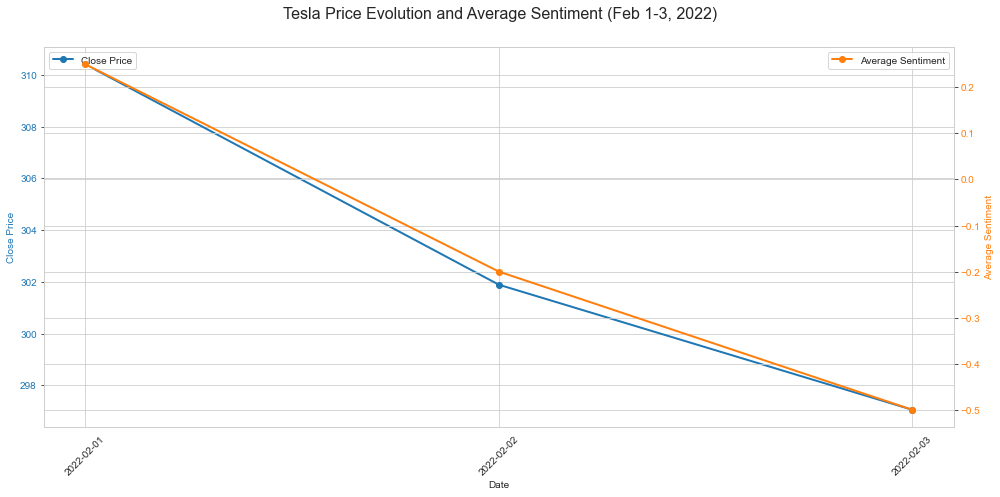

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'tsla_data (1).csv'  # Replace with the correct file path
data = pd.read_csv(file_path, delimiter=';')

# Calculate the weighted sentiment score
data['weighted_sentiment'] = data['avg_sentiment'] * np.log1p(data['submission_count'])

# Sort the data by date to maintain the chronological order
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')

# Filter the data for the specific 3-day horizon (February 1-3, 2022)
filtered_data = data[(data['date'] >= '2022-02-01') & (data['date'] <= '2022-02-03')]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the closing price
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(filtered_data['date'], filtered_data['Close'], color=color, marker='o', linestyle='-', linewidth=2, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(filtered_data['date'])
ax1.set_xticklabels(filtered_data['date'].dt.strftime('%Y-%m-%d'), rotation=45)

# Create a second y-axis for the average sentiment
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Average Sentiment', color=color)
ax2.plot(filtered_data['date'], filtered_data['avg_sentiment'], color=color, marker='o', linestyle='-', linewidth=2, label='Average Sentiment')
ax2.tick_params(axis='y', labelcolor=color)

# Adding title and legend
fig.suptitle('Tesla Price Evolution and Average Sentiment (Feb 1-3, 2022)', fontsize=16)
fig.tight_layout()  # Adjust subplots to fit into figure area.
fig.subplots_adjust(top=0.9)  # Adjust the top to fit the suptitle
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()


## Price and sentiment not evolving in the same way

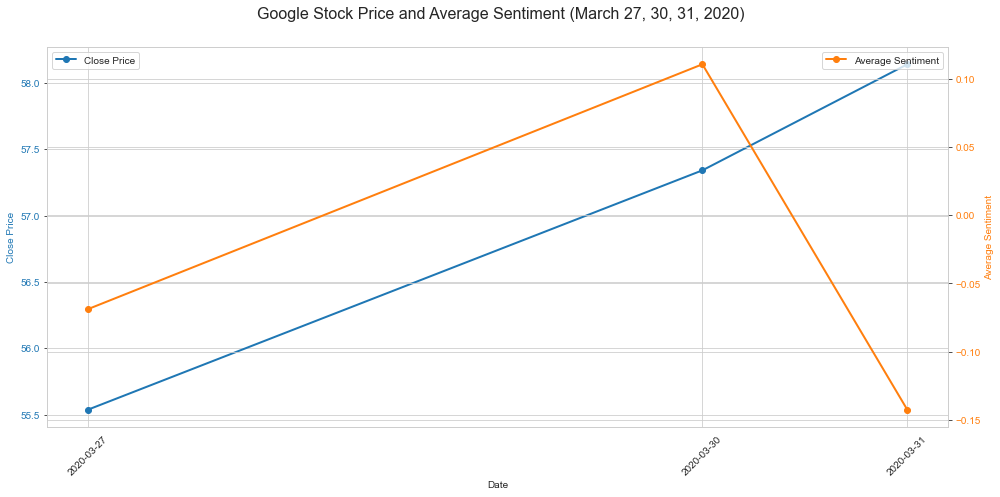

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'goog_data_bis (1).csv'  # Replace with the correct file path
data = pd.read_csv(file_path, delimiter=';')

# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Filter the data for the specific 3-day horizon (March 27, 30, 31, 2020)
filtered_data = data[(data['date'] >= '2020-03-27') & (data['date'] <= '2020-03-31')]

# Plot the price evolution and average sentiment over the specific 3-day horizon
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the closing price
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(filtered_data['date'], filtered_data['Close'], color='tab:blue', marker='o', linestyle='-', linewidth=2, label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(filtered_data['date'])
ax1.set_xticklabels(filtered_data['date'].dt.strftime('%Y-%m-%d'), rotation=45)

# Create a second y-axis for the average sentiment
ax2 = ax1.twinx()
ax2.set_ylabel('Average Sentiment', color='tab:orange')
ax2.plot(filtered_data['date'], filtered_data['avg_sentiment'], color='tab:orange', marker='o', linestyle='-', linewidth=2, label='Average Sentiment')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Adding title and legend
fig.suptitle('Google Stock Price and Average Sentiment (March 27, 30, 31, 2020)', fontsize=16)
fig.tight_layout()  # Adjust subplots to fit into figure area.
fig.subplots_adjust(top=0.9)  # Adjust the top to fit the suptitle
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.show()


## What has gone after the 3 days window

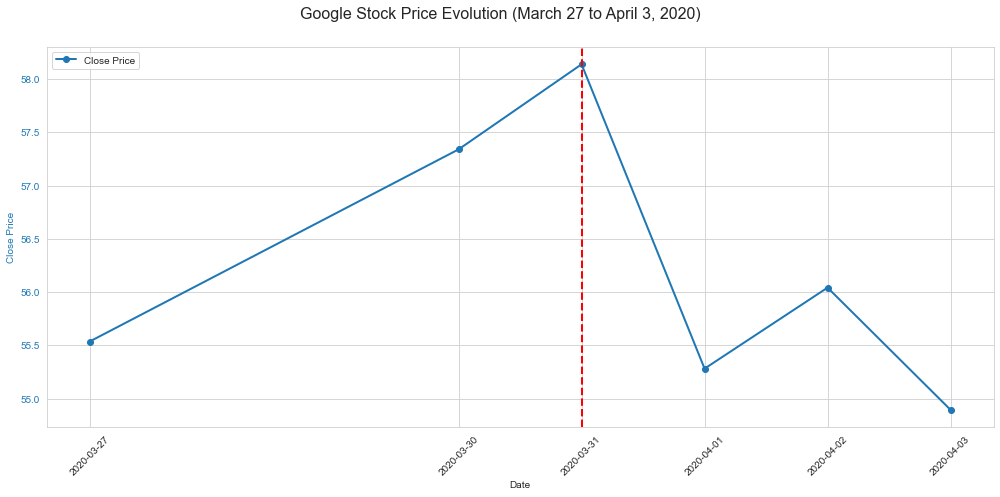

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'goog_data_bis (1).csv'  # Replace with the correct file path
data = pd.read_csv(file_path, delimiter=';')

# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Filter the data for the specific 6-day horizon (March 27 to April 3, 2020)
filtered_data = data[(data['date'] >= '2020-03-27') & (data['date'] <= '2020-04-03')]

# Plot the price evolution over the specific 6-day horizon
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the closing price
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(filtered_data['date'], filtered_data['Close'], color='tab:blue', marker='o', linestyle='-', linewidth=2, label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(filtered_data['date'])
ax1.set_xticklabels(filtered_data['date'].dt.strftime('%Y-%m-%d'), rotation=45)

# Add a vertical line after 2020-03-31 to mark the separation
ax1.axvline(pd.to_datetime('2020-03-31'), color='red', linestyle='--', linewidth=2)

# Adding title and legend
fig.suptitle('Google Stock Price Evolution (March 27 to April 3, 2020)', fontsize=16)
fig.tight_layout()  # Adjust subplots to fit into figure area.
fig.subplots_adjust(top=0.9)  # Adjust the top to fit the suptitle
ax1.legend(loc='upper left')

# Show plot
plt.show()